### Deep Latent Policy Gradient

In [1]:
import numpy as np
import torch
import torch.nn as nn  
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from dpp import ikdpp
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.12.0.dev20220519]


### Util

In [2]:
def torch2np(x_torch):
    if x_torch is None:
        x_np = None
    else:
        x_np = x_torch.detach().cpu().numpy()
    return x_np
def np2torch(x_np,device='cpu'):
    if x_np is None:
        x_torch = None
    else:
        x_torch = torch.tensor(x_np,dtype=torch.float32,device=device)
    return x_torch
print ("Done.")

Done.


### Define DLPG class

In [3]:
class DeepLatentPolicyGradientClass(nn.Module):
    def __init__(
        self,
        name     = 'DLPG',              
        x_dim    = 784,              # input dimension
        c_dim    = 10,               # condition dimension
        z_dim    = 16,               # latent dimension
        h_dims   = [64,32],          # hidden dimensions of encoder (and decoder)
        actv_enc = nn.ReLU(),        # encoder activation
        actv_dec = nn.ReLU(),        # decoder activation
        actv_q   = nn.Softplus(),    # q activation
        actv_out = None,             # output activation
        var_max  = None,             # maximum variance
        device   = 'cpu'
        ):
        """
            Initialize
        """
        super(DeepLatentPolicyGradientClass,self).__init__()
        self.name = name
        self.x_dim    = x_dim
        self.c_dim    = c_dim
        self.z_dim    = z_dim
        self.h_dims   = h_dims
        self.actv_enc = actv_enc
        self.actv_dec = actv_dec
        self.actv_q   = actv_q
        self.actv_out = actv_out
        self.var_max  = var_max
        self.device   = device
        # Initialize layers
        self.init_layers()
        self.init_params()
        # Test
        self.test()
        
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = {}
        
        # Encoder part
        h_dim_prev = self.x_dim + self.c_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['enc_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['enc_%02d_actv'%(h_idx)] = \
                self.actv_enc
            h_dim_prev = h_dim
        self.layers['z_mu_lin']  = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        self.layers['z_var_lin'] = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        
        # Decoder part
        h_dim_prev = self.z_dim + self.c_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['dec_%02d_lin'%(h_idx)]  = \
                nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['dec_%02d_actv'%(h_idx)] = \
                self.actv_dec
            h_dim_prev = h_dim
        self.layers['out_lin'] = nn.Linear(h_dim_prev,self.x_dim,bias=True)
        
        # Append parameters
        self.param_dict = {}
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                self.param_dict[key+'_w'] = layer.weight
                self.param_dict[key+'_b'] = layer.bias
        self.cvae_parameters = nn.ParameterDict(self.param_dict)
        
    def xc_to_z_mu(
        self,
        x = torch.randn(2,784),
        c = torch.randn(2,10)
        ):
        """
            x and c to z_mu
        """
        if c is not None:
            net = torch.cat((x,c),dim=1)
        else:
            net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        z_mu = self.layers['z_mu_lin'](net)
        return z_mu
    
    def xc_to_z_var(
        self,
        x = torch.randn(2,784),
        c = torch.randn(2,10)
        ):
        """
            x and c to z_var
        """
        if c is not None:
            net = torch.cat((x,c),dim=1)
        else:
            net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        net = self.layers['z_var_lin'](net)
        if self.var_max is None:
            net = torch.exp(net)
        else:
            net = self.var_max*torch.sigmoid(net)
        z_var = net
        return z_var
    
    def zc_to_x_recon(
        self,
        z = torch.randn(2,16),
        c = torch.randn(2,10)
        ):
        """
            z and c to x_recon
        """
        if c is not None:
            net = torch.cat((z,c),dim=1)
        else:
            net = z
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon
    
    def xc_to_z_sample(
        self,
        x = torch.randn(2,784),
        c = torch.randn(2,10)
        ):
        """
            x and c to z_sample
        """
        z_mu,z_var = self.xc_to_z_mu(x=x,c=c),self.xc_to_z_var(x=x,c=c)
        eps_sample = torch.randn(
            size=z_mu.shape,dtype=torch.float32).to(self.device)
        z_sample   = z_mu + torch.sqrt(z_var+1e-10)*eps_sample
        return z_sample
    
    def xc_to_x_recon(
        self,
        x             = torch.randn(2,784),
        c             = torch.randn(2,10), 
        STOCHASTICITY = True
        ):
        """
            x and c to x_recon
        """
        if STOCHASTICITY:
            z_sample = self.xc_to_z_sample(x=x,c=c)
        else:
            z_sample = self.xc_to_z_mu(x=x,c=c)
        x_recon = self.zc_to_x_recon(z=z_sample,c=c)
        return x_recon
    
    def sample_x(
        self,
        c        = torch.randn(5,10),
        n_sample = 5
        ):
        """
            Sample x
        """
        z_sample = torch.randn(
            size=(n_sample,self.z_dim),dtype=torch.float32).to(self.device)
        return self.zc_to_x_recon(z=z_sample,c=c),z_sample
    
    def init_params(self):
        """
            Initialize parameters
        """
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.01)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer,nn.BatchNorm2d):
                nn.init.constant_(layer.weight,1.0)
                nn.init.constant_(layer.bias,0.0)
            elif isinstance(layer,nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
                
    def test(
        self,
        batch_size = 4
        ):
        """
            Unit tests
        """
        x_test   = torch.randn(batch_size,self.x_dim)
        if self.c_dim > 0:
            c_test = torch.randn(batch_size,self.c_dim)
        else:
            c_test = None
        z_test   = torch.randn(batch_size,self.z_dim)
        z_mu     = self.xc_to_z_mu(x=x_test,c=c_test)
        z_var    = self.xc_to_z_var(x=x_test,c=c_test)
        x_recon  = self.zc_to_x_recon(z=z_test,c=c_test)
        z_sample = self.xc_to_z_sample(x=x_test,c=c_test)
        x_recon  = self.xc_to_x_recon(x=x_test,c=c_test)
    
    def loss_recon(
        self,
        x               = torch.randn(2,784),
        c               = torch.randn(2,10),
        q               = torch.ones(2),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0,
        STOCHASTICITY   = True
        ):
        """
            Recon loss
        """
        x_recon = self.xc_to_x_recon(x=x,c=c,STOCHASTICITY=STOCHASTICITY)
        if (LOSS_TYPE == 'L1') or (LOSS_TYPE == 'MAE'):
            errs = torch.mean(torch.abs(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L2') or (LOSS_TYPE == 'MSE'):
            errs = torch.mean(torch.square(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L1+L2') or (LOSS_TYPE == 'EN'):
            errs = torch.mean(
                0.5*(torch.abs(x-x_recon)+torch.square(x-x_recon)),axis=1)
        else:
            raise Exception("VAE:[%s] Unknown loss_type:[%s]"%
                            (self.name,LOSS_TYPE))
        # Weight errors by q
        if self.actv_q is not None: q = self.actv_q(q)
        errs = errs*q # [N]
        return recon_loss_gain*torch.mean(errs)
    
    def loss_kl(
        self,
        x = torch.randn(2,784),
        c = torch.randn(2,10),
        q = torch.randn(2)
        ):
        """
            KLD loss
        """
        z_mu     = self.xc_to_z_mu(x=x,c=c)
        z_var    = self.xc_to_z_var(x=x,c=c)
        z_logvar = torch.log(z_var)
        errs     = 0.5*torch.sum(z_var + z_mu**2 - 1.0 - z_logvar,axis=1)
        # Weight errors by q
        if self.actv_q is not None: q = self.actv_q(q)
        errs     = errs*q # [N]
        return torch.mean(errs)
        
    def loss_total(
        self,
        x               = torch.randn(2,784),
        c               = torch.randn(2,10),
        q               = torch.ones(2),
        LOSS_TYPE       = 'L1+L2',
        recon_loss_gain = 1.0,
        STOCHASTICITY   = True,
        beta            = 1.0
        ):
        """
            Total loss
        """
        loss_recon_out = self.loss_recon(
            x               = x,
            c               = c,
            q               = q,
            LOSS_TYPE       = LOSS_TYPE,
            recon_loss_gain = recon_loss_gain,
            STOCHASTICITY   = STOCHASTICITY
        )
        loss_kl_out    = beta*self.loss_kl(
            x = x,
            c = c,
            q = q
        )
        loss_total_out = loss_recon_out + loss_kl_out
        info           = {'loss_recon_out' : loss_recon_out,
                          'loss_kl_out'    : loss_kl_out,
                          'loss_total_out' : loss_total_out,
                          'beta'           : beta}
        return loss_total_out,info
    
    def debug_plot_img(
        self,
        x_train_np     = np.zeros((60000,784)),  # to plot encoded latent space 
        y_train_np     = np.zeros((60000)),      # to plot encoded latent space 
        c_train_np     = np.zeros((60000,10)),   # to plot encoded latent space
        x_test_np      = np.zeros((10000,784)),
        c_test_np      = np.zeros((10000,10)),
        c_vecs         = np.eye(10,10),
        n_sample       = 10,
        img_shape      = (28,28),
        img_cmap       = 'gray',
        figsize_image  = (10,3.25),
        figsize_latent = (10,3.25),
        DPP_GEN        = False,
        dpp_hyp        = {'g':1.0,'l':0.1}
        ):
        """
            Debug plot
        """
        n_train            = x_train_np.shape[0]
        z_prior_np         = np.random.randn(n_train,self.z_dim)
        x_train_torch      = np2torch(x_train_np)
        c_train_torch      = np2torch(c_train_np)
        z_mu_train_np      = torch2np(self.xc_to_z_mu(x_train_torch,c_train_torch))
        z_sample_train_out = torch2np(
            self.xc_to_z_sample(x_train_torch,c_train_torch))
        
        # Reconstruct
        x_test_torch       = np2torch(x_test_np)
        c_test_torch       = np2torch(c_test_np)
        n_test             = x_test_np.shape[0]
        rand_idxs          = np.random.permutation(n_test)[:n_sample]
        if self.c_dim > 0:
            x_recon = self.xc_to_x_recon(
                x = x_test_torch[rand_idxs,:],
                c = c_test_torch[rand_idxs,:]).detach().cpu().numpy()
        else:
            x_recon = self.xc_to_x_recon(
                x = x_test_torch[rand_idxs,:],
                c = None).detach().cpu().numpy()
        
        # Plot images to reconstruct
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_test_np[rand_idxs[s_idx],:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Images to Reconstruct",fontsize=15);plt.show()
        
        # Plot reconstructed images
        fig = plt.figure(figsize=figsize_image)
        for s_idx in range(n_sample):
            plt.subplot(1,n_sample,s_idx+1)
            plt.imshow(x_recon[s_idx,:].reshape(img_shape),
                       vmin=0,vmax=1,cmap=img_cmap)
            plt.axis('off')
        fig.suptitle("Reconstructed Images",fontsize=15);plt.show()
        
        # Plot conditioned generated images
        if DPP_GEN:
            n_sample_total = 100
            z_sample_total = np.random.randn(n_sample_total,self.z_dim)
            z_sample,_ = ikdpp(
                xs_total = z_sample_total,
                qs_total = None,
                n_select = n_sample,
                n_trunc  = n_sample_total,
                hyp      = dpp_hyp)
        else:
            z_sample = np.random.randn(n_sample,self.z_dim)
        z_sample_torch = np2torch(z_sample)
        c_vecs_torch   = np2torch(c_vecs)
        
        # Plot (conditioned) generated images
        if self.c_dim > 0:
            for r_idx in range(c_vecs.shape[0]):
                c_torch  = c_vecs_torch[r_idx,:].reshape((1,-1))
                c_np     = c_vecs[r_idx,:]
                fig      = plt.figure(figsize=figsize_image)
                for s_idx in range(n_sample):
                    z_torch = z_sample_torch[s_idx,:].reshape((1,-1))
                    x_recon = self.zc_to_x_recon(z=z_torch,c=c_torch)
                    x_reocn_np = torch2np(x_recon)
                    plt.subplot(1,n_sample,s_idx+1)
                    plt.imshow(x_reocn_np.reshape(img_shape),vmin=0,vmax=1,cmap=img_cmap)
                    plt.axis('off')
                fig.suptitle("Conditioned Generated Images c:%s"%
                             (c_np),fontsize=15);plt.show()
        else:
            fig = plt.figure(figsize=figsize_image)
            for s_idx in range(n_sample):
                z_torch = z_sample_torch[s_idx,:].reshape((1,-1))
                x_recon = self.zc_to_x_recon(z=z_torch,c=None)
                x_reocn_np = torch2np(x_recon)
                plt.subplot(1,n_sample,s_idx+1)
                plt.imshow(x_reocn_np.reshape(img_shape),vmin=0,vmax=1,cmap=img_cmap)
                plt.axis('off')
            fig.suptitle("Generated Images",fontsize=15);plt.show()
            
        # Plot latent space of training inputs
        fig = plt.figure(figsize=figsize_latent)
        # Plot samples from the prior
        plt.subplot(1,3,1) # z prior
        plt.scatter(z_prior_np[:,0],z_prior_np[:,1],marker='.',s=0.5,c='k',alpha=0.5)
        plt.title('z prior',fontsize=13)
        plt.xlim(-3,+3); plt.ylim(-3,+3)
        plt.gca().set_aspect('equal', adjustable='box')
        # Plot encoded mean
        plt.subplot(1,3,2) # z mu
        plt.scatter(
            x      = z_mu_train_np[:,0],
            y      = z_mu_train_np[:,1],
            c      = y_train_np,
            cmap   = 'rainbow',
            marker = '.',
            s      = 0.5,
            alpha  = 0.5)
        plt.title('z mu',fontsize=13)
        plt.xlim(-3,+3); plt.ylim(-3,+3)
        plt.gca().set_aspect('equal', adjustable='box')
        # Plot samples
        plt.subplot(1,3,3) # z sample
        sc = plt.scatter(
            x      = z_sample_train_out[:,0],
            y      = z_sample_train_out[:,1],
            c      = y_train_np,
            cmap   = 'rainbow',
            marker = '.',
            s      = 0.5,
            alpha  = 0.5)
        plt.plot(z_sample[:,0],z_sample[:,1],'o',mec='k',mfc='none',ms=10)
        colors = [plt.cm.rainbow(a) for a in np.linspace(0.0,1.0,10)]
        for c_idx in range(10):
            plt.plot(10,10,'o',mfc=colors[c_idx],mec=colors[c_idx],ms=6,
                     label='%d'%(c_idx)) # outside the axis, only for legend
        plt.legend(fontsize=8,loc='upper right')
        plt.title('z sample',fontsize=13)
        plt.xlim(-3,+3); plt.ylim(-3,+3)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show() # plot latent spaces
        
print ("Done.")

Done.


### MNIST

In [4]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(
    root='../data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test  = datasets.MNIST(
    root='../data/',train=False,transform=transforms.ToTensor(),download=True)
# Training data
x_train_torch               = mnist_train.data.float().reshape(-1,784)/255.
y_train_torch               = mnist_train.targets
x_test_torch                = mnist_test.data.float().reshape(-1,784)/255.
y_test_torch                = mnist_test.targets
x_train_np,x_test_np        = torch2np(x_train_torch),torch2np(x_test_torch)
y_train_np,y_test_np        = torch2np(y_train_torch),torch2np(y_test_torch)
c_train_np,c_test_np        = np.eye(10,10)[y_train_np],np.eye(10,10)[y_test_np]
n_train,n_test              = x_train_np.shape[0],x_test_np.shape[0]
c_train_torch,c_test_torch  = np2torch(c_train_np),np2torch(c_test_np)
print ("x_train_np:%s x_test_np:%s"%(x_train_np.shape,x_test_np.shape,))
print ("c_train_np:%s c_test_np:%s"%(c_train_np.shape,c_test_np.shape,))
print ("n_train:[%d] n_test:[%d]"%(n_train,n_test))

x_train_np:(60000, 784) x_test_np:(10000, 784)
c_train_np:(60000, 10) c_test_np:(10000, 10)
n_train:[60000] n_test:[10000]


### DLPG with MNIST
We assign $ q = 0.1 \times (x+1) - 0.5$ where $x \in [0,1,\ldots, 9]$ is the number of of the digit.

In [5]:
def q_func(q_in):
    q_out = 0.1*(q_in+1.0)-0.5
    return q_out*10
q_train_np,q_test_np       = q_func(y_train_np),q_func(y_test_np)
q_train_torch,q_test_torch = np2torch(q_train_np),np2torch(q_test_np)
print ("Done.")

Done.


### Conditioned DLPG

[DLPG] instantiated
<bound method Module.parameters of DeepLatentPolicyGradientClass(
  (actv_enc): ReLU()
  (actv_dec): ReLU()
  (actv_q): Softplus(beta=1, threshold=20)
  (cvae_parameters): ParameterDict(
      (dec_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x12]
      (dec_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (enc_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x794]
      (enc_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (out_lin_b): Parameter containing: [torch.FloatTensor of size 784]
      (out_lin_w): Parameter containing: [torch.FloatTensor of size 784x256]
      (z_mu_lin_b): 

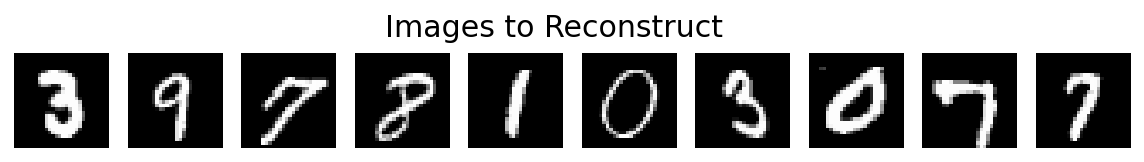

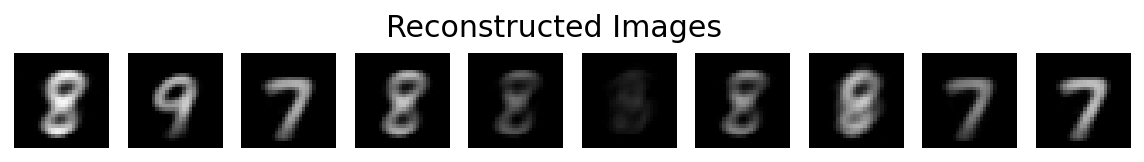

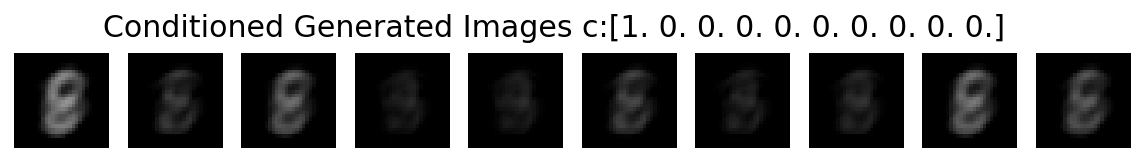

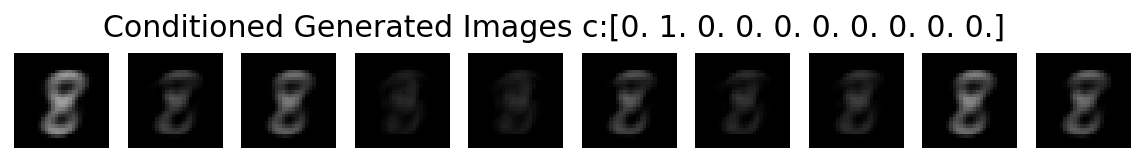

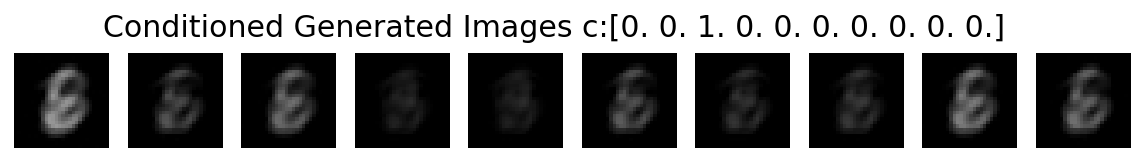

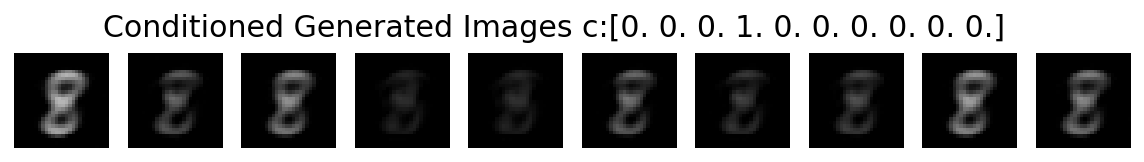

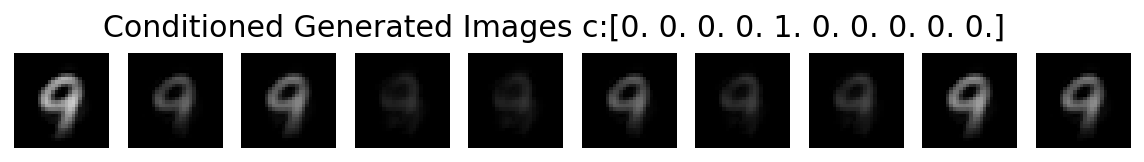

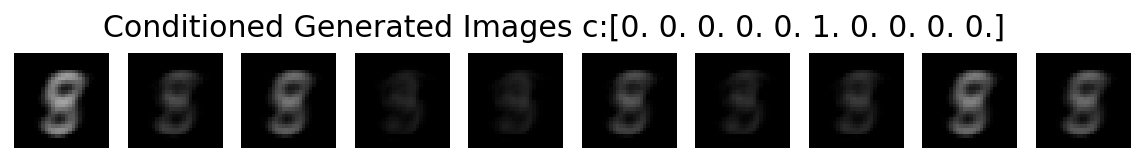

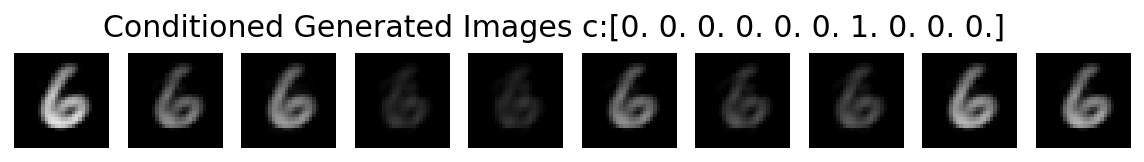

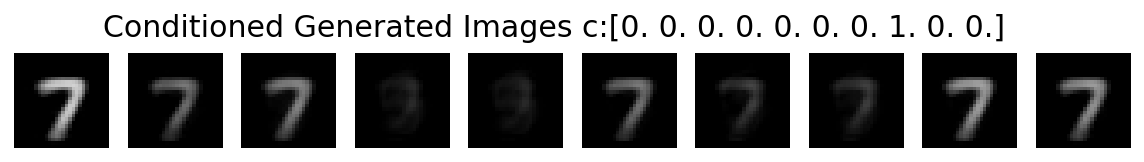

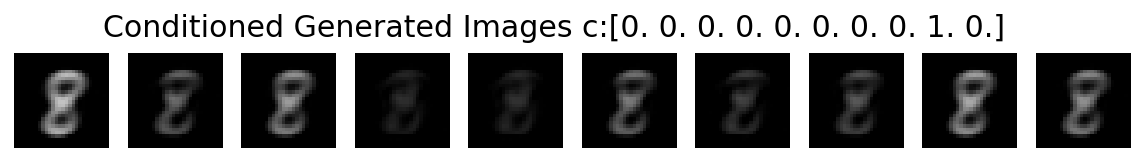

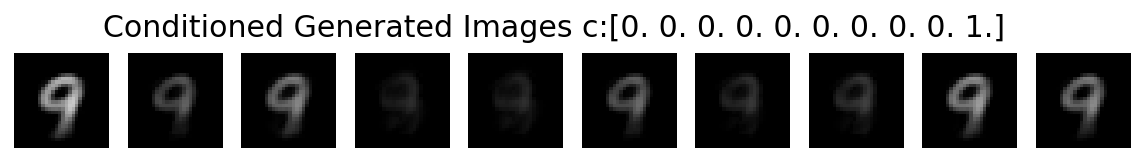

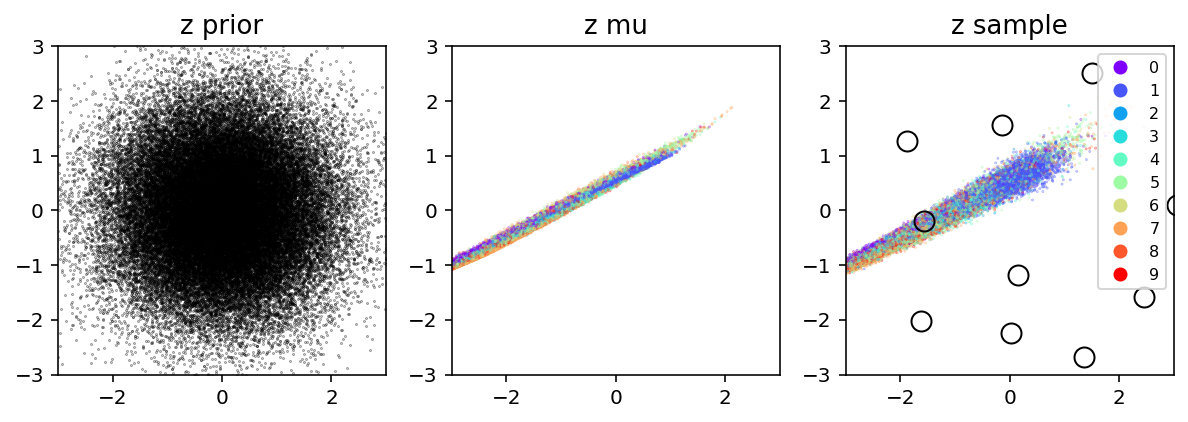

[1/100] total:[1.219] recon:[1.219] kl:[0.000]
[2/100] total:[1.048] recon:[1.048] kl:[0.000]
[3/100] total:[0.993] recon:[0.993] kl:[0.000]
[4/100] total:[0.965] recon:[0.965] kl:[0.000]
[5/100] total:[0.948] recon:[0.948] kl:[0.000]
[6/100] total:[0.937] recon:[0.937] kl:[0.000]
[7/100] total:[0.928] recon:[0.928] kl:[0.000]
[8/100] total:[0.921] recon:[0.921] kl:[0.000]
[9/100] total:[0.914] recon:[0.914] kl:[0.000]
[10/100] total:[0.910] recon:[0.910] kl:[0.000]
[11/100] total:[0.905] recon:[0.905] kl:[0.000]
[12/100] total:[0.901] recon:[0.901] kl:[0.000]
[13/100] total:[0.898] recon:[0.898] kl:[0.000]
[14/100] total:[0.895] recon:[0.895] kl:[0.000]
[15/100] total:[0.892] recon:[0.892] kl:[0.000]
[16/100] total:[0.890] recon:[0.890] kl:[0.000]
[17/100] total:[0.888] recon:[0.888] kl:[0.000]
[18/100] total:[0.885] recon:[0.885] kl:[0.000]
[19/100] total:[0.883] recon:[0.883] kl:[0.000]
[20/100] total:[0.914] recon:[0.887] kl:[0.027]
[21/100] total:[0.908] recon:[0.885] kl:[0.023]
[

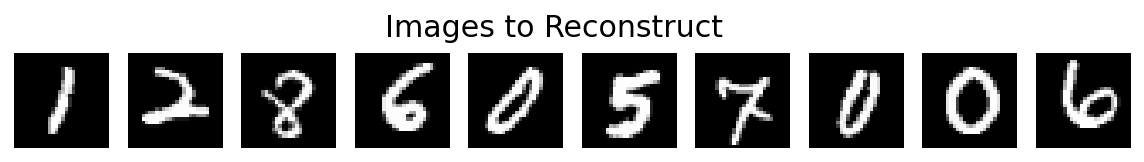

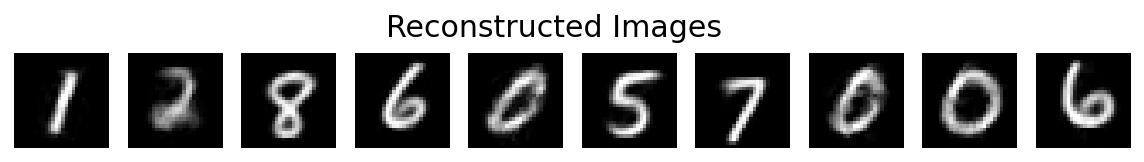

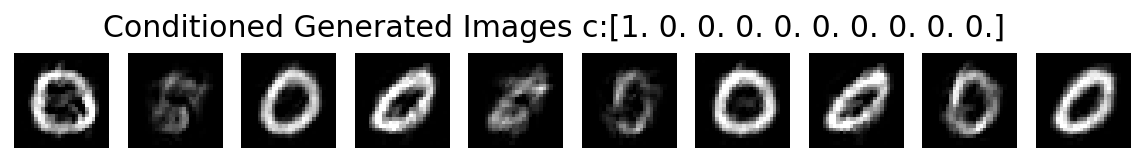

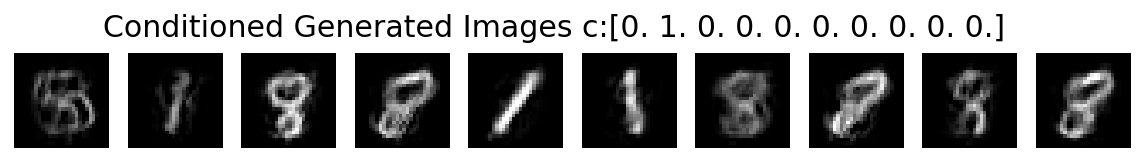

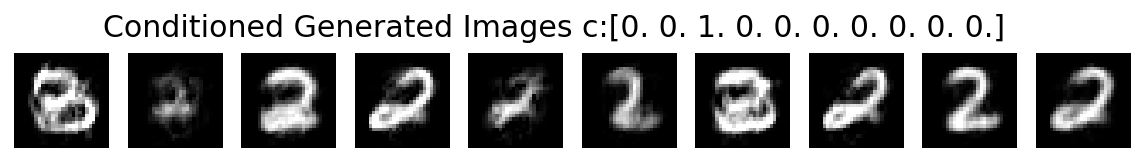

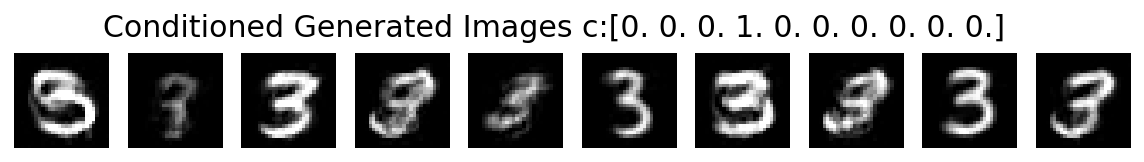

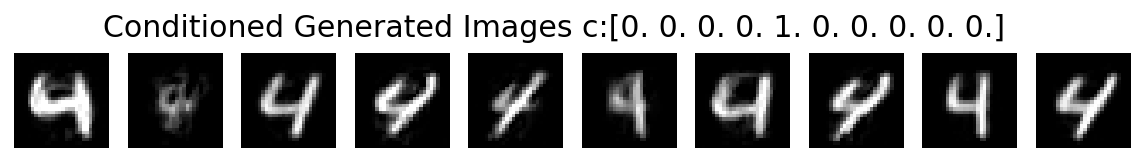

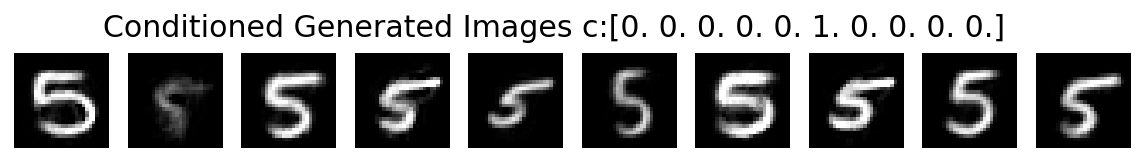

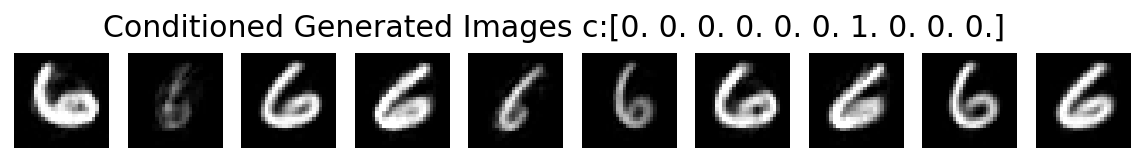

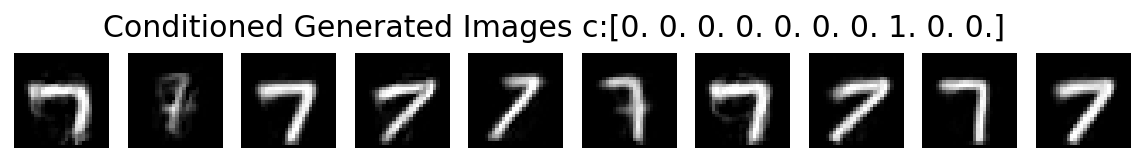

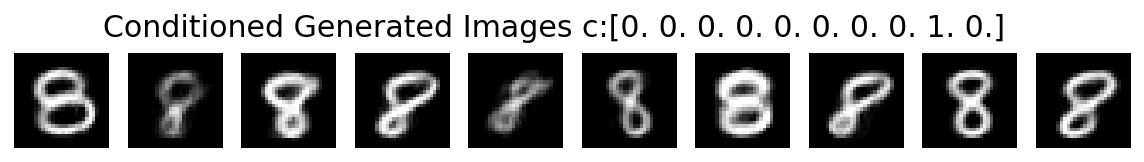

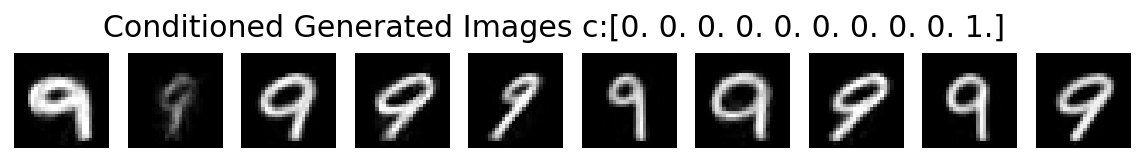

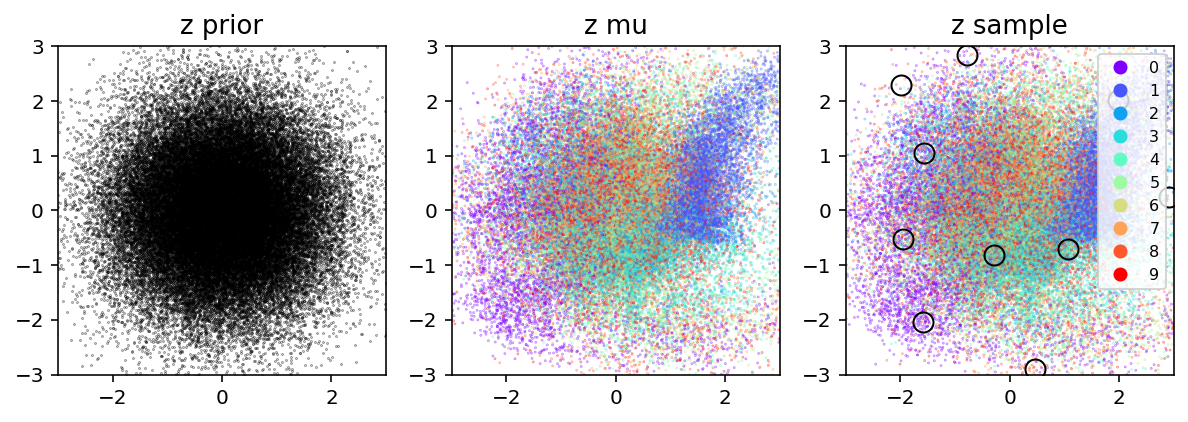

[51/100] total:[0.903] recon:[0.859] kl:[0.045]
[52/100] total:[0.903] recon:[0.858] kl:[0.045]
[53/100] total:[0.904] recon:[0.858] kl:[0.046]
[54/100] total:[0.904] recon:[0.857] kl:[0.047]
[55/100] total:[0.904] recon:[0.857] kl:[0.047]
[56/100] total:[0.904] recon:[0.856] kl:[0.048]
[57/100] total:[0.904] recon:[0.856] kl:[0.049]
[58/100] total:[0.905] recon:[0.856] kl:[0.049]
[59/100] total:[0.905] recon:[0.855] kl:[0.050]
[60/100] total:[0.906] recon:[0.855] kl:[0.051]
[61/100] total:[0.906] recon:[0.855] kl:[0.051]
[62/100] total:[0.907] recon:[0.854] kl:[0.052]
[63/100] total:[0.906] recon:[0.854] kl:[0.053]
[64/100] total:[0.908] recon:[0.854] kl:[0.054]
[65/100] total:[0.908] recon:[0.853] kl:[0.054]
[66/100] total:[0.908] recon:[0.853] kl:[0.055]
[67/100] total:[0.909] recon:[0.853] kl:[0.056]
[68/100] total:[0.909] recon:[0.853] kl:[0.056]
[69/100] total:[0.909] recon:[0.852] kl:[0.057]
[70/100] total:[0.910] recon:[0.852] kl:[0.058]
[71/100] total:[0.910] recon:[0.852] kl:

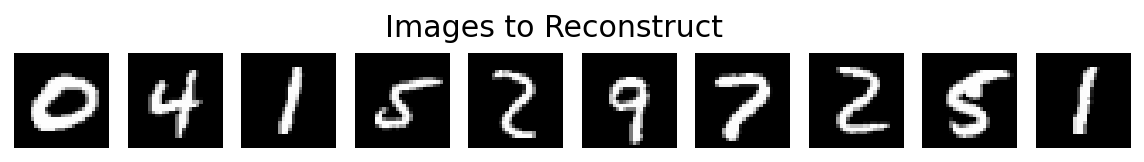

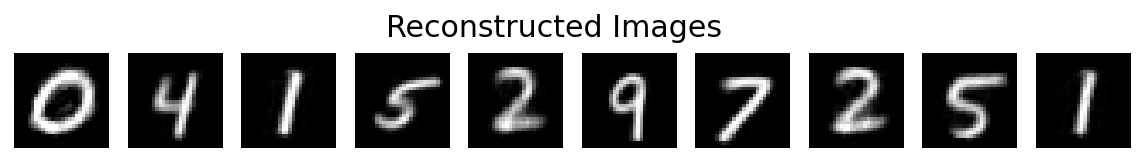

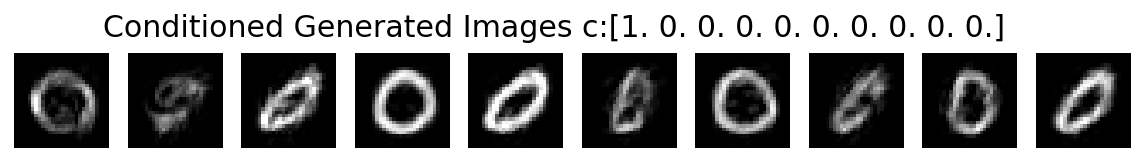

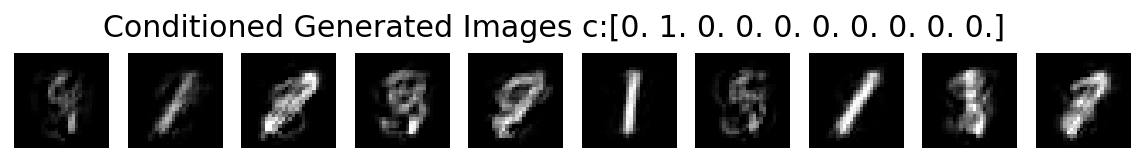

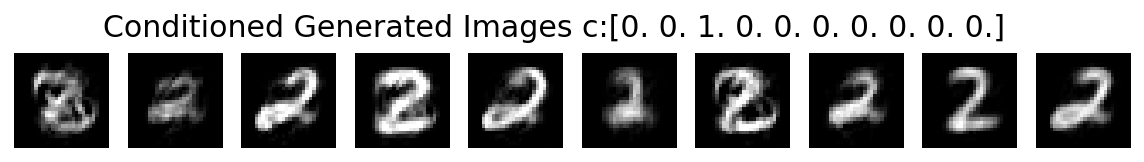

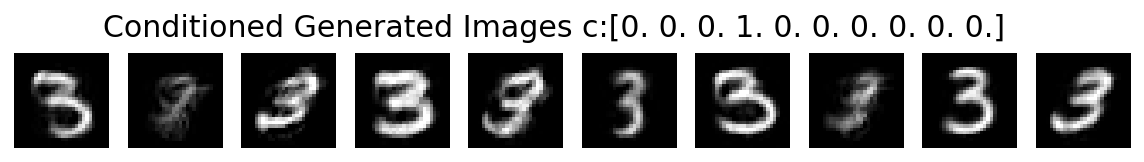

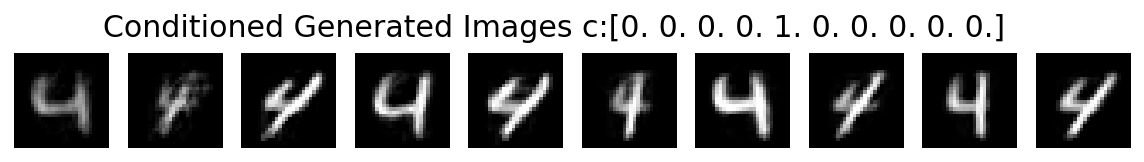

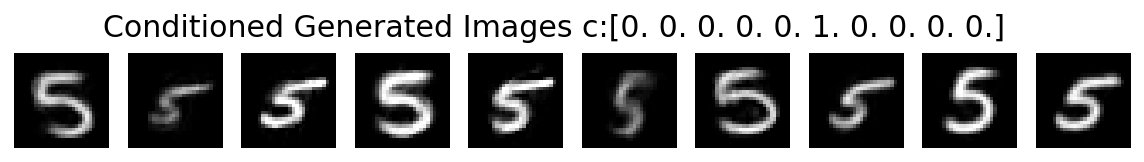

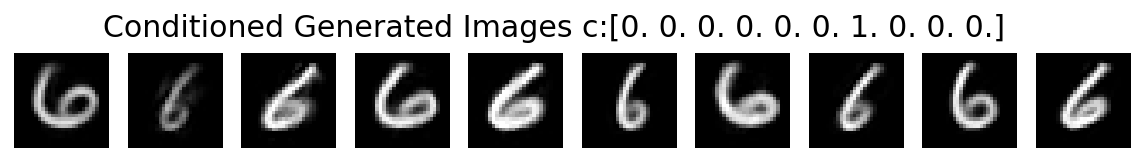

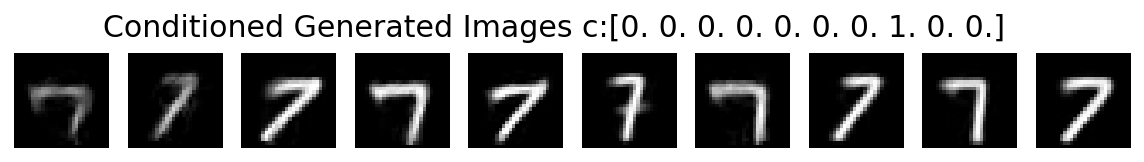

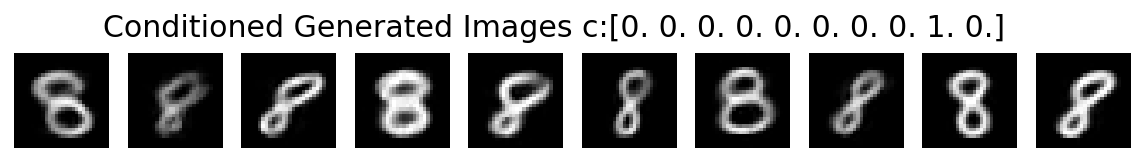

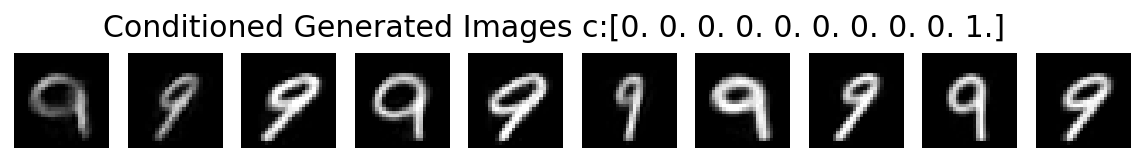

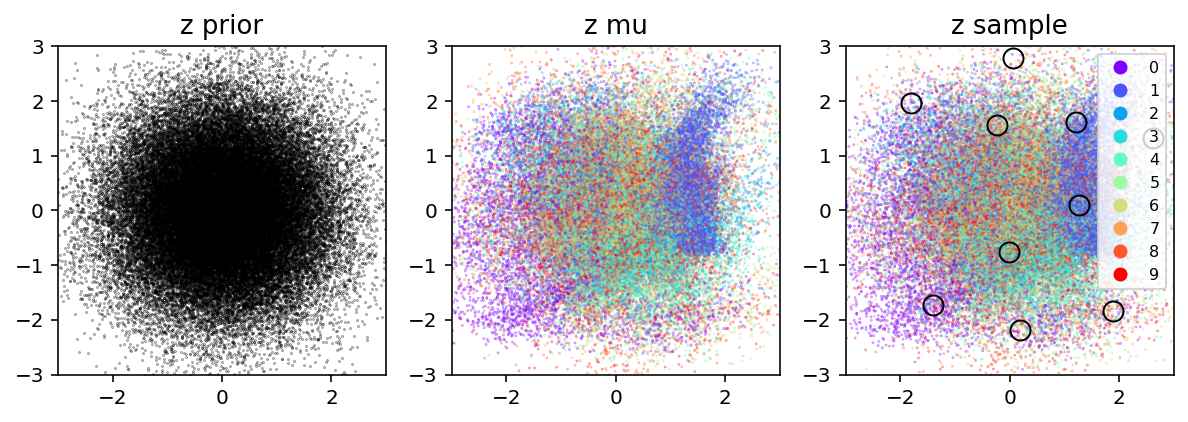

Done.


In [6]:
D = DeepLatentPolicyGradientClass(
    name     = 'DLPG',
    x_dim    = 784,
    c_dim    = 10,
    z_dim    = 2,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_q   = nn.Softplus(),
    actv_out = None,
    var_max  = 0.1,
    device   ='cpu',
    )
print ("[%s] instantiated"%(D.name))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,1,128,50
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = D.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-4        # 1e-8
) 
print (D.parameters)

D.init_params()
dpi = {'x_train_np':x_train_np,'y_train_np':y_train_np,'c_train_np':c_train_np,
       'x_test_np':x_test_np,'c_test_np':c_test_np,'c_vecs':np.eye(10,10),
       'figsize_image':(10,1.25),'figsize_latent':(10,3.25),
       'DPP_GEN':True,'dpp_hyp':{'g':1.0,'l':1.0}}
# D.debug_plot_img(**dpi)
print ("Start training.")
for epoch in range(n_epoch):
    zero_to_one = float(epoch/(n_epoch-1))
    if epoch >= 20: beta = 0.01
    else:           beta = 0.0
    loss_recon_sum,loss_kl_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:]
        c_batch_torch = c_train_torch[batch_idx,:]
        q_batch_torch = q_train_torch[batch_idx]
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = D.loss_total(
            x               = x_batch_torch,
            c               = c_batch_torch,
            q               = q_batch_torch,
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 10.0,
            beta            = beta*zero_to_one,
            STOCHASTICITY   = True)
        optm.zero_grad(); total_loss_out.backward(); optm.step()
        # Errors
        loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_kl_sum    = loss_kl_sum + n_batch*loss_info['loss_kl_out']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_kl_avg    = loss_kl_sum / n_batch_sum
    
    # Print
    print ("[%d/%d] total:[%.3f] recon:[%.3f] kl:[%.3f]"%
           (epoch,n_epoch,loss_total_avg,loss_recon_avg,loss_kl_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        D.debug_plot_img(**dpi)
print ("Done.")

### Uncnditioned DLPG

[DLPG] instantiated
<bound method Module.parameters of DeepLatentPolicyGradientClass(
  (actv_enc): ReLU()
  (actv_dec): ReLU()
  (actv_q): Softplus(beta=1, threshold=20)
  (cvae_parameters): ParameterDict(
      (dec_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x2]
      (dec_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (enc_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x784]
      (enc_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (out_lin_b): Parameter containing: [torch.FloatTensor of size 784]
      (out_lin_w): Parameter containing: [torch.FloatTensor of size 784x256]
      (z_mu_lin_b): P

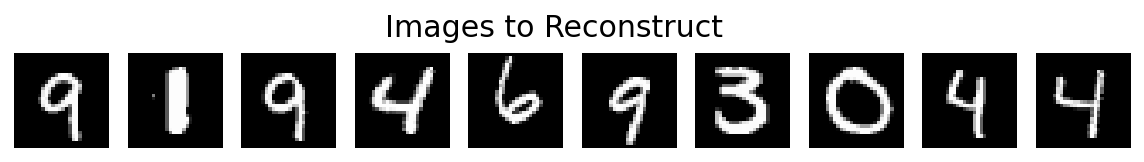

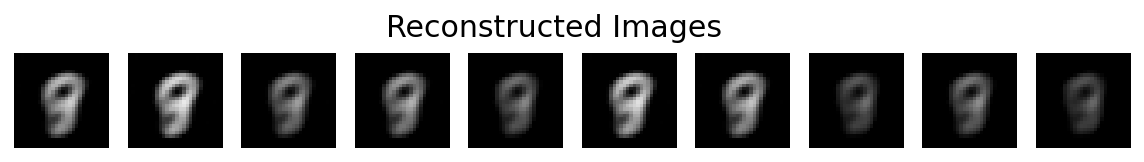

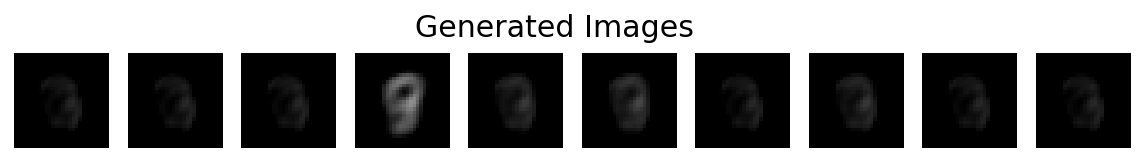

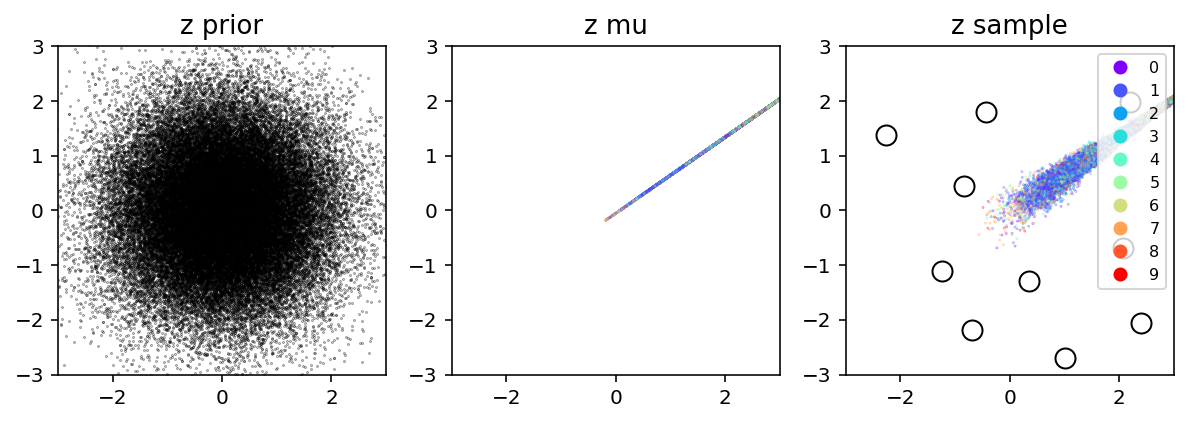

[1/100] total:[1.430] recon:[1.430] kl:[0.000]
[2/100] total:[1.250] recon:[1.250] kl:[0.000]
[3/100] total:[1.139] recon:[1.139] kl:[0.000]
[4/100] total:[1.088] recon:[1.088] kl:[0.000]
[5/100] total:[1.061] recon:[1.061] kl:[0.000]
[6/100] total:[1.043] recon:[1.043] kl:[0.000]
[7/100] total:[1.029] recon:[1.029] kl:[0.000]
[8/100] total:[1.020] recon:[1.020] kl:[0.000]
[9/100] total:[1.011] recon:[1.011] kl:[0.000]
[10/100] total:[1.003] recon:[1.003] kl:[0.000]
[11/100] total:[0.996] recon:[0.996] kl:[0.000]
[12/100] total:[0.990] recon:[0.990] kl:[0.000]
[13/100] total:[0.983] recon:[0.983] kl:[0.000]
[14/100] total:[0.976] recon:[0.976] kl:[0.000]
[15/100] total:[0.972] recon:[0.972] kl:[0.000]
[16/100] total:[0.966] recon:[0.966] kl:[0.000]
[17/100] total:[0.962] recon:[0.962] kl:[0.000]
[18/100] total:[0.957] recon:[0.957] kl:[0.000]
[19/100] total:[0.954] recon:[0.954] kl:[0.000]
[20/100] total:[0.999] recon:[0.959] kl:[0.040]
[21/100] total:[0.986] recon:[0.956] kl:[0.030]
[

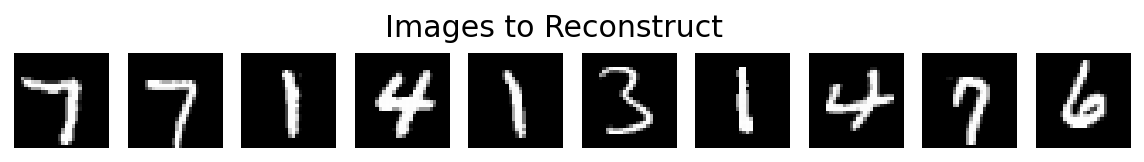

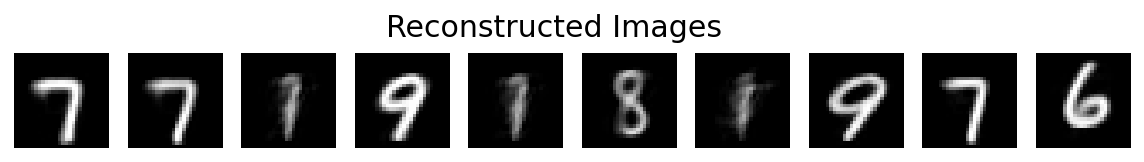

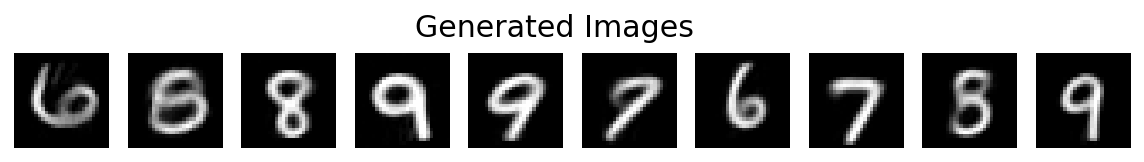

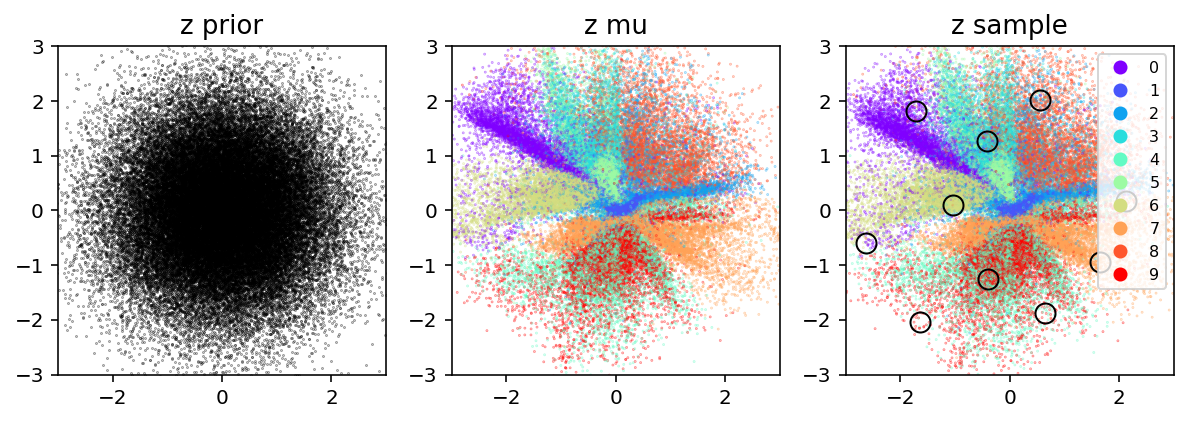

[51/100] total:[0.978] recon:[0.924] kl:[0.054]
[52/100] total:[0.977] recon:[0.921] kl:[0.055]
[53/100] total:[0.979] recon:[0.923] kl:[0.056]
[54/100] total:[0.978] recon:[0.921] kl:[0.057]
[55/100] total:[0.978] recon:[0.920] kl:[0.058]
[56/100] total:[0.979] recon:[0.920] kl:[0.059]
[57/100] total:[0.979] recon:[0.920] kl:[0.060]
[58/100] total:[0.979] recon:[0.919] kl:[0.061]
[59/100] total:[0.980] recon:[0.918] kl:[0.062]
[60/100] total:[0.981] recon:[0.919] kl:[0.063]
[61/100] total:[0.982] recon:[0.919] kl:[0.063]
[62/100] total:[0.984] recon:[0.920] kl:[0.064]
[63/100] total:[0.984] recon:[0.918] kl:[0.065]
[64/100] total:[0.984] recon:[0.918] kl:[0.066]
[65/100] total:[0.984] recon:[0.917] kl:[0.067]
[66/100] total:[0.987] recon:[0.919] kl:[0.068]
[67/100] total:[0.988] recon:[0.920] kl:[0.069]
[68/100] total:[0.990] recon:[0.921] kl:[0.070]
[69/100] total:[0.989] recon:[0.919] kl:[0.070]
[70/100] total:[0.988] recon:[0.917] kl:[0.071]
[71/100] total:[0.990] recon:[0.918] kl:

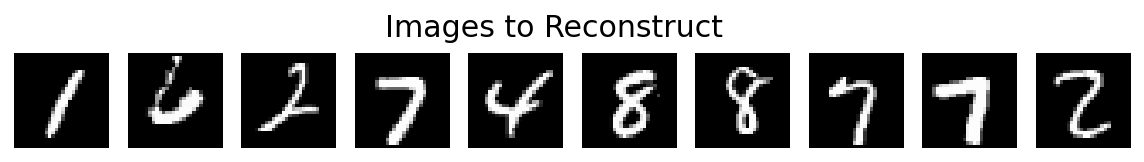

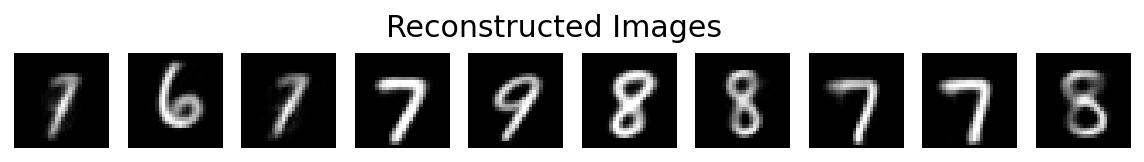

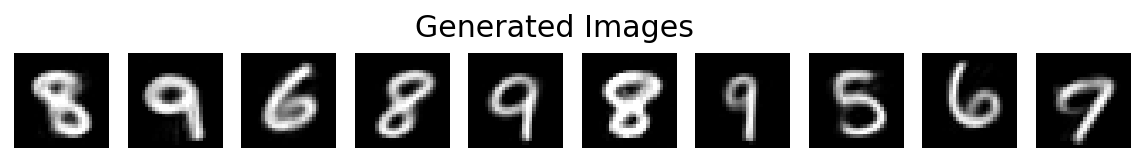

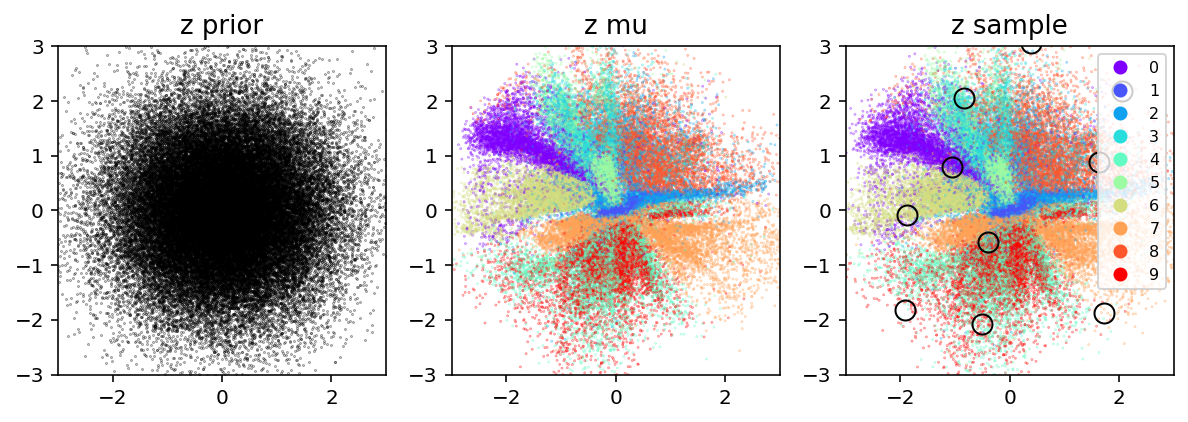

Done.


In [7]:
D = DeepLatentPolicyGradientClass(
    name     = 'DLPG',
    x_dim    = 784,
    c_dim    = 0,
    z_dim    = 2,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_q   = nn.Softplus(),
    actv_out = None,
    var_max  = 0.1,
    device   ='cpu',
    )
print ("[%s] instantiated"%(D.name))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,1,128,50
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = D.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-4        # 1e-8
)
print (D.parameters)

D.init_params()
dpi = {'x_train_np':x_train_np,'y_train_np':y_train_np,'c_train_np':None,
       'x_test_np':x_test_np,'c_test_np':None,'c_vecs':None,
       'figsize_image':(10,1.25),'figsize_latent':(10,3.25),
       'DPP_GEN':True,'dpp_hyp':{'g':1.0,'l':1.0}}
# D.debug_plot_img(**dpi)
print ("Start training.")
for epoch in range(n_epoch):
    zero_to_one = float(epoch/(n_epoch-1))
    if epoch >= 20: beta = 0.01
    else:           beta = 0.0
    loss_recon_sum,loss_kl_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:]
        c_batch_torch = None
        q_batch_torch = q_train_torch[batch_idx]
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = D.loss_total(
            x               = x_batch_torch,
            c               = c_batch_torch,
            q               = q_batch_torch,
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 10.0,
            beta            = beta*zero_to_one,
            STOCHASTICITY   = True)
        optm.zero_grad(); total_loss_out.backward(); optm.step()
        # Errors
        loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_kl_sum    = loss_kl_sum + n_batch*loss_info['loss_kl_out']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_kl_avg    = loss_kl_sum / n_batch_sum
    
    # Print
    print ("[%d/%d] total:[%.3f] recon:[%.3f] kl:[%.3f]"%
           (epoch,n_epoch,loss_total_avg,loss_recon_avg,loss_kl_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        D.debug_plot_img(**dpi)
print ("Done.")